<a href="https://colab.research.google.com/github/nathon-tadeo/4106-Realtime-ML/blob/main/homework_1_real_time_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce RTX 4070 SUPER
Epoch [1/20], Loss: 1.6575, Train Acc: 0.4096, Val Acc: 0.4676
Epoch [11/20], Loss: 0.7423, Train Acc: 0.7313, Val Acc: 0.5366
Epoch [20/20], Loss: 0.3952, Train Acc: 0.8584, Val Acc: 0.5129

Training Time: 207.82 seconds


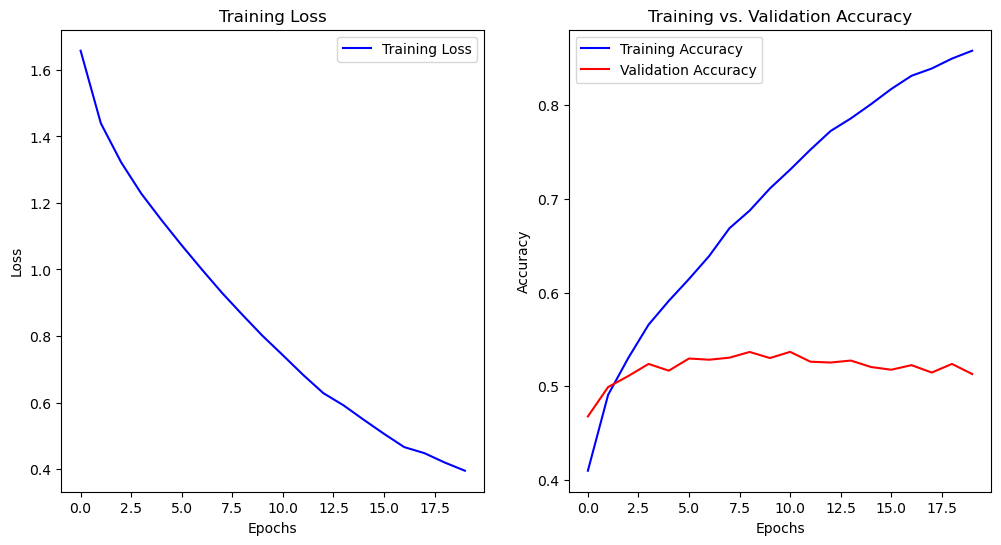

Final Test Accuracy: 0.5129
Precision: 0.5146
Recall: 0.5129
F1 Score: 0.5126


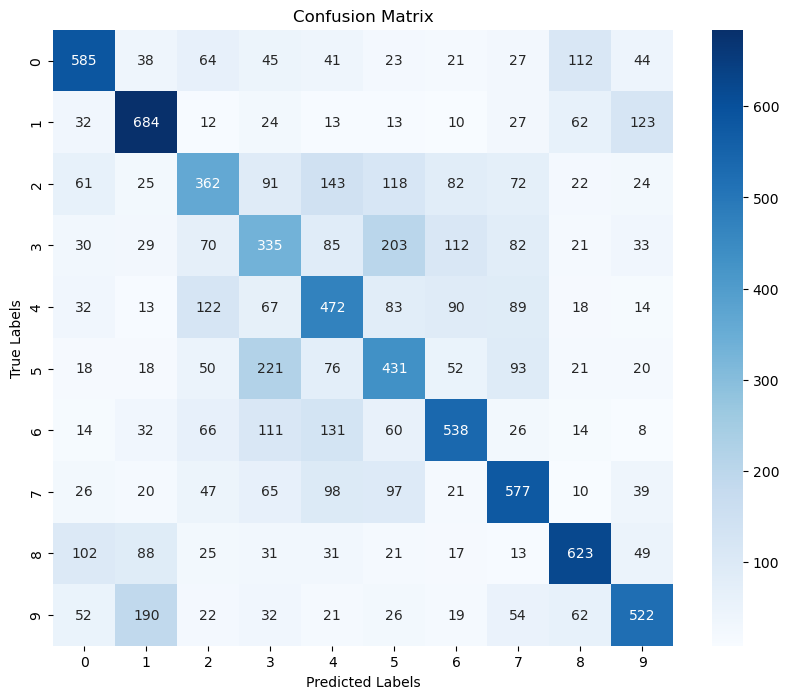

In [ ]:
#code was ran on VScode with Anaconda env
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem 1a: Develop a multi-layer perceptron with three hidden layers
# with CIFAR-10 dataset. Train the model from scratch (with randomized parameters)
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_layer_size = 256
input_size = 3 * 32 * 32  # CIFAR-10 images are 32x32x3
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the Multi-Layer Perceptron model
class CIFAR10MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CIFAR10MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),  # Hidden Layer 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 2
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 3
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),  # Output Layer
        )

    def forward(self, x):
        return self.model(x)


# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
# Evaluate on validation data
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Loss: {train_losses[-1]:.4f}, "
                f"Train Acc: {train_accuracy:.4f}, "
                f"Val Acc: {val_accuracy:.4f}"
            )

    total_time = time.time() - start_time
    return train_losses, train_accuracies, val_accuracies, total_time


# Initialize Model, Loss Function, and Optimizer
model = CIFAR10MLP(input_size, hidden_layer_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Evaluation Metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print Metrics
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Epoch [1/20], Loss: 1.7505, Train Acc: 0.3711, Val Acc: 0.4516
Epoch [11/20], Loss: 0.7806, Train Acc: 0.7204, Val Acc: 0.5420
Epoch [20/20], Loss: 0.4267, Train Acc: 0.8516, Val Acc: 0.5393

Training Time: 218.11 seconds


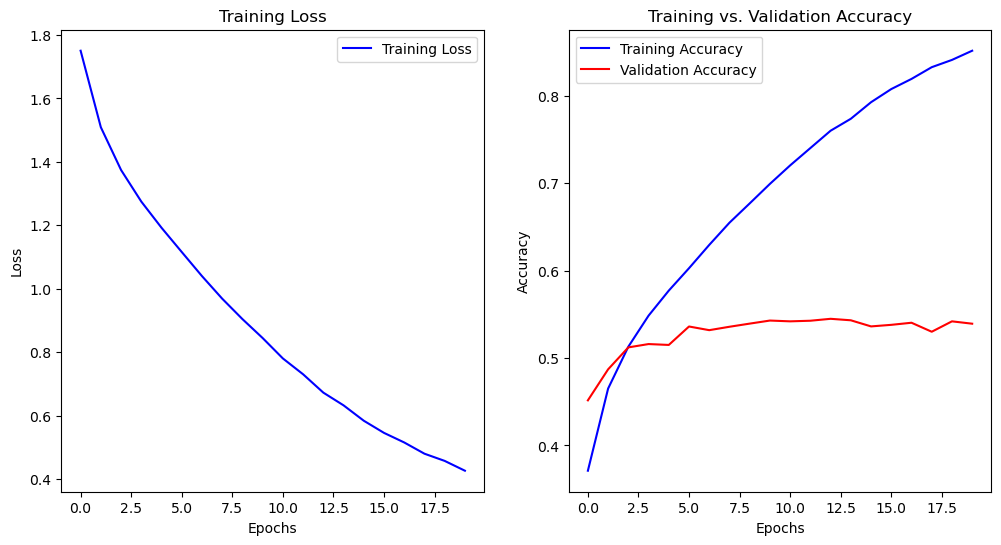

Final Test Accuracy: 0.5393
Precision: 0.5405
Recall: 0.5393
F1 Score: 0.5387


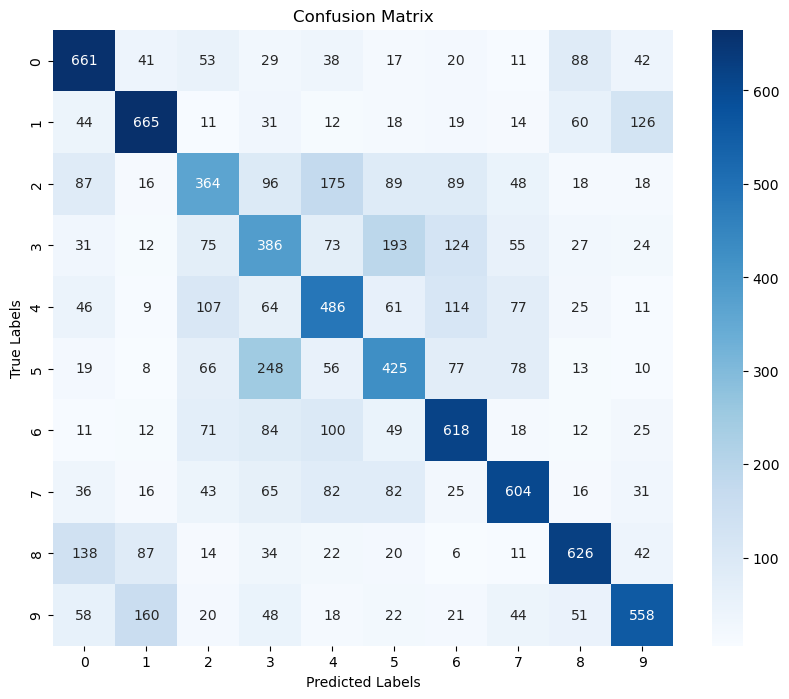

In [ ]:
#1b.Explore the complexity of the network by increasing its width and depth

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
hidden_layer_size = 512
input_size = 3 * 32 * 32  # CIFAR-10 images are 32x32x3
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_dataset = datasets.CIFAR10(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the Multi-Layer Perceptron model
class CIFAR10MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CIFAR10MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),  # Hidden Layer 1
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 2
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 3
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 4
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Hidden Layer 5
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),  # Output Layer
        )

    def forward(self, x):
        return self.model(x)


# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
# Evaluate on validation data
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Loss: {train_losses[-1]:.4f}, "
                f"Train Acc: {train_accuracy:.4f}, "
                f"Val Acc: {val_accuracy:.4f}"
            )

    total_time = time.time() - start_time
    return train_losses, train_accuracies, val_accuracies, total_time


# Initialize Model, Loss Function, and Optimizer
model = CIFAR10MLP(input_size, hidden_layer_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, train_accuracies, val_accuracies, training_time = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)


print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final Evaluation on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Evaluation Metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print Metrics
print(f"Final Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Epoch [1/100], Train Loss: 26469930996726.6055, Val Loss: 25188991238144.0000
Epoch [11/100], Train Loss: 20209520272938.2734, Val Loss: 18439750025216.0000
Epoch [21/100], Train Loss: 3456449358707.0825, Val Loss: 3308160286720.0000
Epoch [31/100], Train Loss: 1646642637532.7708, Val Loss: 1416757116928.0000
Epoch [41/100], Train Loss: 1375207142315.4495, Val Loss: 1124408623104.0000
Epoch [51/100], Train Loss: 1272307090610.4954, Val Loss: 1046742302720.0000
Epoch [61/100], Train Loss: 1209097147232.2935, Val Loss: 1016678318080.0000
Epoch [71/100], Train Loss: 1172495942233.2478, Val Loss: 996157095936.0000
Epoch [81/100], Train Loss: 1148634710241.4678, Val Loss: 985701875712.0000
Epoch [91/100], Train Loss: 1132633028955.5964, Val Loss: 973929971712.0000
Epoch [100/100], Train Loss: 1125510964101.8716, Val Loss: 969636052992.0000


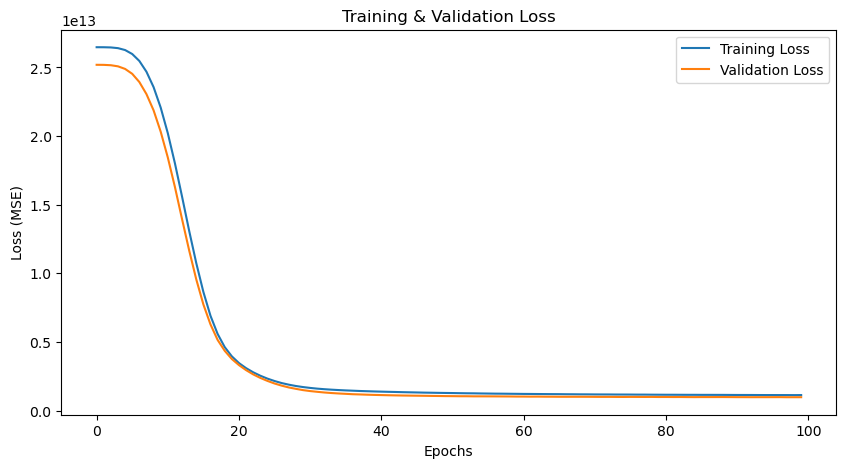


Final Model Performance:
MSE: 969636184064.00
RMSE: 984701.06
R² Score: 0.6635


In [ ]:
#2 Build a multi-perceptron network that regresses the housing price (based on 20%, 80% split) no on-hot encoding
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the dataset
URL = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'
housing = pd.read_csv(URL)

# Convert categorical variables to binary
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

varlist = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[varlist] = housing[varlist].apply(binary_map)

# Define input features and target variable
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement',
             'hotwaterheating', 'airconditioning', 'parking', 'prefarea']]
y = housing['price']

# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoader
batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Multi-Layer Perceptron Model
class HousingMLP(nn.Module):
    def __init__(self, input_size):
        super(HousingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),  # Hidden Layer 1
            nn.ReLU(),
            nn.Linear(64, 32),  # Hidden Layer 2
            nn.ReLU(),
            nn.Linear(32, 16),  # Hidden Layer 3
            nn.ReLU(),
            nn.Linear(16, 1)  # Output Layer (Regression)
        )

    def forward(self, x):
        return self.model(x)

    # Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = HousingMLP(input_size).to(device)
criterion = nn.MSELoss()  # Regression loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, prices in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert to numpy
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Compute MSE, RMSE, and R²
mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
r2_score = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

print(f"\nFinal Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2_score:.4f}")

Epoch [1/100], Train Loss: 26469912435007.4141, Val Loss: 25188913643520.0000
Epoch [11/100], Train Loss: 19957169482160.1484, Val Loss: 18092277104640.0000
Epoch [21/100], Train Loss: 3541901406095.2661, Val Loss: 3315679625216.0000
Epoch [31/100], Train Loss: 1681003089957.5779, Val Loss: 1513775824896.0000
Epoch [41/100], Train Loss: 1355690165877.4312, Val Loss: 1185295892480.0000
Epoch [51/100], Train Loss: 1237516143005.3579, Val Loss: 1099009818624.0000
Epoch [61/100], Train Loss: 1165584276226.3486, Val Loss: 1055768313856.0000
Epoch [71/100], Train Loss: 1121266205371.8899, Val Loss: 1029095620608.0000
Epoch [81/100], Train Loss: 1096852356856.9541, Val Loss: 1011584401408.0000
Epoch [91/100], Train Loss: 1074320165747.0825, Val Loss: 999645184000.0000
Epoch [100/100], Train Loss: 1062270550279.0459, Val Loss: 992468795392.0000


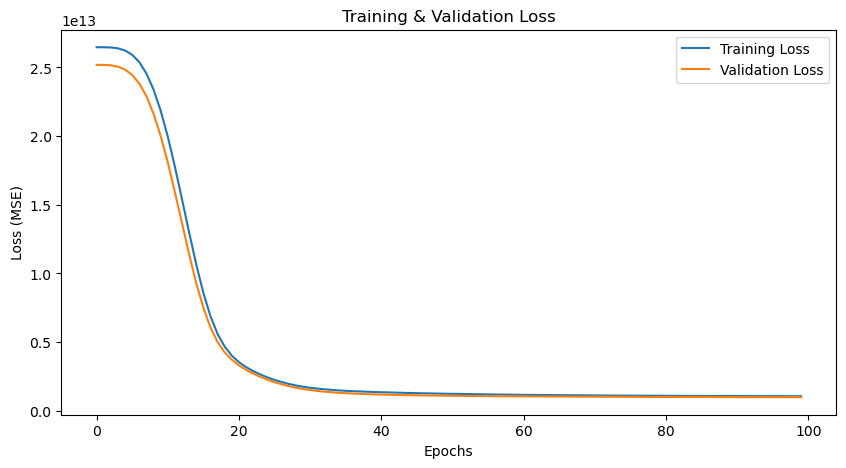


Final Model Performance:
MSE: 992468860928.00
RMSE: 996227.31
R² Score: 0.6556


In [ ]:
#2b. Add on-hot encoding
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Device Configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
URL = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'
housing = pd.read_csv(URL)

# Convert binary categorical variables to numerical (yes/no → 1/0)
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[binary_vars] = housing[binary_vars].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# Identify categorical variables for One-Hot Encoding
categorical_vars = ['furnishingstatus']  # Example categorical variable (modify if needed)

# Apply One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(housing[categorical_vars])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_vars))

# Drop original categorical columns and concatenate encoded columns
housing = housing.drop(columns=categorical_vars)
housing = pd.concat([housing, encoded_df], axis=1)

# Define input features and target variable
X = housing.drop(columns=['price'])  # Remove target variable
y = housing['price']

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoaders
batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-Layer Perceptron (MLP) Model
class HousingMLP(nn.Module):
    def __init__(self, input_size):
        super(HousingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model, Loss Function, and Optimizer
input_size = X_train.shape[1]  # Adjusted after One-Hot Encoding
model = HousingMLP(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, prices in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation Loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert to NumPy Arrays
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Compute MSE, RMSE, and R² Score
mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
r2_score = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

print(f"\nFinal Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2_score:.4f}")


Epoch [1/100], Train Loss: 26469955508393.1016, Val Loss: 25189123358720.0000
Epoch [11/100], Train Loss: 21398495053429.4297, Val Loss: 19434466967552.0000
Epoch [21/100], Train Loss: 4796475954617.5410, Val Loss: 3373452230656.0000
Epoch [31/100], Train Loss: 3191274997064.8071, Val Loss: 1870477000704.0000
Epoch [41/100], Train Loss: 3365148493279.1191, Val Loss: 1626658177024.0000
Epoch [51/100], Train Loss: 3192467632766.8257, Val Loss: 4958756274176.0000
Epoch [61/100], Train Loss: 2644475709421.2109, Val Loss: 1695932612608.0000
Epoch [71/100], Train Loss: 2537037819415.4863, Val Loss: 2049108738048.0000
Epoch [81/100], Train Loss: 2480008527477.4312, Val Loss: 1868211814400.0000
Epoch [91/100], Train Loss: 2670483112725.1377, Val Loss: 1724869640192.0000
Epoch [100/100], Train Loss: 2451601595514.1284, Val Loss: 1459334021120.0000


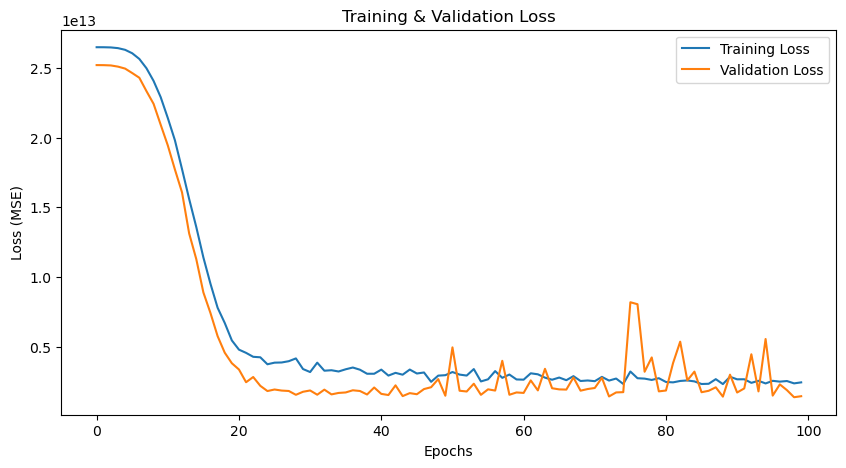


Final Model Performance:
MSE: 1459334021120.00
RMSE: 1208029.00
R² Score: 0.4936


In [ ]:
#2c. Add on-hot encoding
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Device Configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
URL = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/Housing.csv'
housing = pd.read_csv(URL)

# Convert binary categorical variables to numerical (yes/no → 1/0)
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[binary_vars] = housing[binary_vars].apply(lambda x: x.map({'yes': 1, 'no': 0}))

# Identify categorical variables for One-Hot Encoding
categorical_vars = ['furnishingstatus']  # Example categorical variable (modify if needed)

# Apply One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(housing[categorical_vars])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_vars))

# Drop original categorical columns and concatenate encoded columns
housing = housing.drop(columns=categorical_vars)
housing = pd.concat([housing, encoded_df], axis=1)

# Define input features and target variable
X = housing.drop(columns=['price'])  # Remove target variable
y = housing['price']

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Create DataLoaders
batch_size = 4
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multi-Layer Perceptron (MLP) Model
class HousingMLP(nn.Module):
    def __init__(self, input_size):
        super(HousingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # Increased neurons
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.Dropout(0.3),  # Dropout for regularization

            nn.Linear(128, 64),  # Increased neurons
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # Output layer remains the same
        )

    def forward(self, x):
        return self.model(x)

# Initialize Model, Loss Function, and Optimizer
input_size = X_train.shape[1]  # Adjusted after One-Hot Encoding
model = HousingMLP(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for features, prices in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation Loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Convert to NumPy Arrays
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Compute MSE, RMSE, and R² Score
mse = np.mean((y_pred - y_true) ** 2)
rmse = np.sqrt(mse)
r2_score = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

print(f"\nFinal Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2_score:.4f}")
